# Recursive Retriever

In this notebook we will experiment with `RecursiveRetriever` module over hierarchical data.

* The concept of recursive retrieval is that we not only explore the directly most relevant nodes, but also explore node relationships to additional retrievers/query engines and execute them.

* For instance, a node may represent a concise summary of a structured table, and link to a SQL/Pandas query engine over that structured table. Then if the node is retrieved, we want to also query the underlying query engine for the answer.

* This can be especially useful for documents with hierarchical relationships. In this example, we walk through a Wikipedia article about billionaires (in PDF form), which contains both text and a variety of embedded structured tables.

* We first create a Pandas query engine over each table, but also represent each table by an `IndexNode` (stores a link to the query engine); this Node is stored along with other Nodes in a vector store.

* During query-time, if an IndexNode is fetched, then the underlying query engine/retriever will be queried.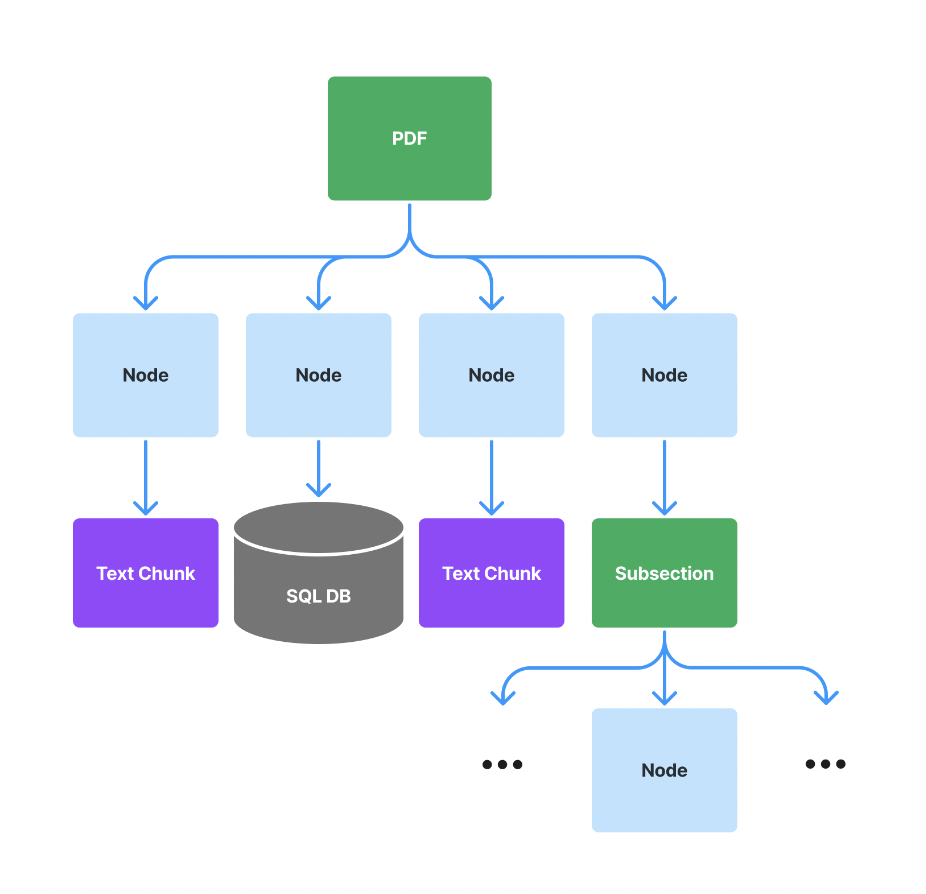

In [ ]:
!pip install camelot-py ghostscript
!sudo apt install ghostscript python3-tk

In [1]:
import os 
from dotenv import load_dotenv, find_dotenv

In [2]:
load_dotenv('/home/santhosh/Projects/courses/Pinnacle/.env')

True

In [3]:
OPENAI_API_KEY = os.environ['OPENAI_API_KEY']

In [4]:
# The nest_asyncio module enables the nesting of asynchronous functions within an already running async loop.
# This is necessary because Jupyter notebooks inherently operate in an asynchronous loop.
# By applying nest_asyncio, we can run additional async functions within this existing loop without conflicts.
import nest_asyncio

nest_asyncio.apply()

In [5]:
import camelot
from llama_index.core import Document
from llama_index.core import VectorStoreIndex
from llama_index.core.query_engine import PandasQueryEngine, RetrieverQueryEngine
from llama_index.core.retrievers import RecursiveRetriever
from llama_index.core.schema import IndexNode
from llama_index.llms.openai import OpenAI
from llama_index.core import download_loader
from typing import List

## Download data from [here](https://github.com/run-llama/llama_index/blob/9607a05a923ddf07deee86a56d386b42943ce381/docs/docs/examples/query_engine/pdf_tables/billionaires_page.pdf)


We will use  Wikipedia article about billionaires (in PDF form).

## Load Data

We use our `PyMuPDFReader` to read in the main text of the document.

We also use `camelot` to extract some structured tables from the document

In [7]:
from llama_index.readers.file import PyMuPDFReader

In [8]:
loader = PyMuPDFReader()
docs = loader.load("billionaires_page.pdf")

## Use `camelot` package to parse tables

In [11]:
def get_tables(path: str, pages: List[int]):
    table_dfs = []
    for page in pages:
        table_list = camelot.read_pdf(path, pages=str(page))
        for table in table_list:
          table_df = table.df
          table_df = (
              table_df.rename(columns=table_df.iloc[0])
              .drop(table_df.index[0])
              .reset_index(drop=True)
          )
          table_dfs.append(table_df)
    return table_dfs

In [12]:
# We will get tables from pages 3, 4, 5 and 25
table_dfs = get_tables("billionaires_page.pdf", pages=[3, 4, 5, 25])

In [13]:
len(table_dfs)

6

In [14]:
# shows list of top billionaires in 2023
table_dfs[0]

,No.,Name,Net worth\n(USD),Age,Nationality,Primary source(s) of wealth
0,1,Bernard Arnault &\nfamily,$211 billion,74,France,LVMH
1,2,Elon Musk,$180 billion,51,United\nStates,"Tesla, SpaceX, X Corp."
2,3,Jeff Bezos,$114 billion,59,United\nStates,Amazon
3,4,Larry Ellison,$107 billion,78,United\nStates,Oracle Corporation
4,5,Warren Buffett,$106 billion,92,United\nStates,Berkshire Hathaway
5,6,Bill Gates,$104 billion,67,United\nStates,Microsoft
6,7,Michael Bloomberg,$94.5 billion,81,United\nStates,Bloomberg L.P.
7,8,Carlos Slim & family,$93 billion,83,Mexico,"Telmex, América Móvil, Grupo\nCarso"
8,9,Mukesh Ambani,$83.4 billion,65,India,Reliance Industries
9,10,Steve Ballmer,$80.7 billion,67,United\nStates,Microsoft


In [16]:
# shows list of top billionaires in 2022
table_dfs[1]

,No.,Name,Net worth\n(USD),Age,Nationality,Primary source(s) of\nwealth
0,1,Elon Musk,$219 billion,50,United\nStates,"Tesla, SpaceX, Twitter Inc"
1,2,Jeff Bezos,$177 billion,58,United\nStates,Amazon
2,3,Bernard Arnault &\nfamily,$158 billion,73,France,LVMH
3,4,Bill Gates,$129 billion,66,United\nStates,Microsoft
4,5,Warren Buffett,$118 billion,91,United\nStates,Berkshire Hathaway
5,6,Larry Page,$111 billion,49,United\nStates,Alphabet Inc.
6,7,Sergey Brin,$107 billion,48,United\nStates,Alphabet Inc.
7,8,Larry Ellison,$106 billion,77,United\nStates,Oracle Corporation
8,9,Steve Ballmer,$91.4 billion,66,United\nStates,Microsoft
9,10,Mukesh Ambani,$90.7 billion,64,India,Reliance Industries


In [17]:
# shows list of top billionaires in 2020
table_dfs[3]

,No.,Name,Net worth (USD),Age,Nationality,Source(s) of wealth
0,1,Jeff Bezos,$113 billion,56,United States,Amazon
1,2,Bill Gates,$98 billion,64,United States,Microsoft
2,3,Bernard Arnault & family,$76 billion,71,France,LVMH
3,4,Warren Buffett,$67.5 billion,89,United States,Berkshire Hathaway
4,5,Larry Ellison,$59 billion,75,United States,Oracle Corporation
5,6,Amancio Ortega,$55.1 billion,84,Spain,"Inditex, Zara"
6,7,Mark Zuckerberg,$54.7 billion,35,United States,"Facebook, Inc."
7,8,Jim Walton,$54.6 billion,71,United States,Walmart
8,9,Alice Walton,$54.4 billion,70,United States,Walmart
9,10,S. Robson Walton,$54.1 billion,77,United States,Walmart


In [18]:
# shows list of top billionaires in 2019
table_dfs[4]

,No.,Name,Net worth (USD),Age,Nationality,Source(s) of wealth
0,1,Jeff Bezos,$131 billion,55,United States,Amazon
1,2,Bill Gates,$96.5 billion,63,United States,Microsoft
2,3,Warren Buffett,$82.5 billion,88,United States,Berkshire Hathaway
3,4,Bernard Arnault,$76 billion,70,France,LVMH
4,5,Carlos Slim,$64 billion,79,Mexico,"América Móvil, Grupo Carso"
5,6,Amancio Ortega,$62.7 billion,82,Spain,"Inditex, Zara"
6,7,Larry Ellison,$62.5 billion,74,United States,Oracle Corporation
7,8,Mark Zuckerberg,$62.3 billion,34,United States,"Facebook, Inc."
8,9,Michael Bloomberg,$55.5 billion,77,United States,Bloomberg L.P.
9,10,Larry Page,$50.8 billion,45,United States,Alphabet Inc.


In [19]:
# shows list of top billionaires
table_dfs[5]

,Year,Number of billionaires,Group's combined net worth
0,2023[2],"2,640",$12.2 trillion
1,2022[6],"2,668",$12.7 trillion
2,2021[11],"2,755",$13.1 trillion
3,2020,"2,095",$8.0 trillion
4,2019,"2,153",$8.7 trillion
5,2018,"2,208",$9.1 trillion
6,2017,"2,043",$7.7 trillion
7,2016,"1,810",$6.5 trillion
8,2015[18],"1,826",$7.1 trillion
9,2014[67],"1,645",$6.4 trillion


## Define Pandas query engines over these tables

We create a pandas query engine over each structured table.

These can be executed on their own to answer queries about each table.

In [21]:
llm = OpenAI(model="gpt-3.5-turbo")

df_query_engines = [
    PandasQueryEngine(table_df, llm=llm)
    for table_df in table_dfs
]

In [22]:
response = df_query_engines[0].query(
    "What's the net worth of the second richest billionaire in 2023?"
)
print(str(response))

$180 billion


In [23]:
response = df_query_engines[4].query(
    "How many billionaires were there in 2019?"
)
print(str(response))

10


In [24]:
response

Response(response='10', source_nodes=[], metadata={'pandas_instruction_str': 'df.shape[0]', 'raw_pandas_output': '10'})

## Build Vector Index
Build vector index over the chunked document as well as over the additional `IndexNode` objects linked to the tables.

In [26]:
from llama_index.core import Settings

In [27]:
doc_nodes = Settings.node_parser.get_nodes_from_documents(docs)

In [28]:
# define index nodes
summaries = [
    (
        "This node provides information about the world's richest billionaires"
        " in 2023"
    ),
    (
        "This node provides information about the world's richest billionaires"
        " in 2022"
    ),
    (
        "This node provides information about the world's richest billionaires"
        " in 2021"
    ),
    (
        "This node provides information about the world's richest billionaires"
        " in 2020"
    ),
    (
        "This node provides information about the world's richest billionaires"
        " in 2019"
    ),
    (
        "This node provides information on the number of billionaires and"
        " their combined net worth from 2000 to 2023."
    ),
]

df_nodes = [
    IndexNode(text=summary, index_id=f"pandas{idx}")
    for idx, summary in enumerate(summaries)
]

df_id_query_engine_mapping = {
    f"pandas{idx}": df_query_engine
    for idx, df_query_engine in enumerate(df_query_engines)
}

In [29]:
# construct top-level vector index + query engine
vector_index = VectorStoreIndex(doc_nodes + df_nodes)
vector_retriever = vector_index.as_retriever(similarity_top_k=1)

## Use RecursiveRetriever in our RetrieverQueryEngine

We define a `RecursiveRetriever` object to recursively retrieve/query nodes. We then put this in our `RetrieverQueryEngine` along with a ResponseSynthesizer to synthesize a response.

We pass in mappings from id to retriever and id to query engine. We then pass in a root id representing the retriever we query first.

In [30]:
# baseline vector index (that doesn't include the extra table df nodes).
# used to benchmark
vector_query_engine = VectorStoreIndex(doc_nodes).as_query_engine()

In [31]:
from llama_index.core.retrievers import RecursiveRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.response_synthesizers import get_response_synthesizer

recursive_retriever = RecursiveRetriever(
    "vector",
    retriever_dict={"vector": vector_retriever},
    query_engine_dict=df_id_query_engine_mapping,
    verbose=True,
)

response_synthesizer = get_response_synthesizer(
    response_mode="compact"
)

query_engine = RetrieverQueryEngine.from_args(
    recursive_retriever, response_synthesizer=response_synthesizer
)

## Querying

In [32]:
response = query_engine.query(
    "What's the net worth of the third richest billionaire in 2019?"
)
print(response)

Retrieving with query id None: What's the net worth of the third richest billionaire in 2019?
Retrieved node with id, entering: pandas4
Retrieving with query id pandas4: What's the net worth of the third richest billionaire in 2019?
Got response: $82.5 billion
$82.5 billion


In [33]:
response = vector_query_engine.query(
    "What's the net worth of the third richest billionaire in 2019?"
)
print(response)

$72.8 billion


In [34]:
response = query_engine.query(
    "when did the the list of worlds billionaries was first published in? Tell month and Year."
)
print(response)

Retrieving with query id None: when did the the list of worlds billionaries was first published in? Tell month and Year.
Retrieving text node: 7/1/23, 11:31 PM
The World's Billionaires - Wikipedia
https://en.wikipedia.org/wiki/The_World%27s_Billionaires
32/33
63. "Special Report on The Rich" (http://www.economist.com/node/13356686). The Economist. 4 April
2009. Archived (https://web.archive.org/web/20110112194744/http://www.economist.com/node/13
356686) from the original on 12 January 2011. Retrieved 19 March 2012.
64. "Global Wealth Report 2011" (https://web.archive.org/web/20150923212754/http://www.dasinvest
ment.com/fileadmin/images/pictures/0907/BCG_2011_0106_Global_Wealth_Report_client_versio
n_May2011.pdf) (PDF). The Boston Consulting Group. 31 May 2011. Archived from the original (ht
tp://www.dasinvestment.com/fileadmin/images/pictures/0907/BCG_2011_0106_Global_Wealth_R
eport_client_version_May2011.pdf) (PDF) on 23 September 2015.
65. "World Wealth Report 2011" (https://web.arch

In [35]:
response = query_engine.query("How many billionaires were there in 2009?")
print(response)

Retrieving with query id None: How many billionaires were there in 2009?
Retrieved node with id, entering: pandas5
Retrieving with query id pandas5: How many billionaires were there in 2009?
Got response: 14    793
Name: Number of billionaires, dtype: object
There were 793 billionaires in 2009.


In [37]:
response = vector_query_engine.query(
    "How many billionaires were there in 2009?"
)
print(response)

A total of 1,426 people made the 2013 billionaire list.
